# Analyzing Air Quality and Cancer Rates in California

## Business Problem

Cancer is the second leading cause of mortality in the United States. Over 600,000 people are projected to die from cancer in the U.S. in 2020. Existing evidence from epidemiologic studies suggest that poor air quality is associated with increased risk of mortality for various types of cancer. Our group wanted to understand if there are additional relationships between these environmental factors and lung cancer. Understanding the relationship between lung cancer and the environment could help identify variables that contribute to higher lung cancer rates. We’re interested in examining which types of cancers are most likely to be influenced by environmental factors.

The cost of cancer is high for both the people with cancer and for society. The Agency for Healthcare Research and Quality estimated that the total of all healthcare costs for Cancer in the United States in 2015 were 80.2 billion dollars. Cancer care costs are expected to rise to as high as 173 billion dollars by 2020. Cancer affects the quality of life, community decisions and choices of diagnosed individuals and their families. Socially, the shared perspective of any disease is to prevent it rather than treat it. Concisely identifying the environmental factors could aid in reducing future cases and influence quality of life in the United States. 

In [1]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import functools as ft

## Data Sources

**We'll begin by looking at three distinct sets of data for the state of California and its 58 counties:**

1. EPA AQI (air quality index)
2. SEER STAT Cancer Incidents (lung cancer rates)
3. Health Professional Shortage Areas (HPSA - areas with high mortality rates and a lack of economic and financial resources)
4. California Health Measures (health quality measures across a variety of indicators)


## Below is a breakdown of the various data sets and variables we'll be working with:

### AQI
1. **state:** as we've decided to focus on California, this will only be a sample from this state
2. **county:** AQI data for 53-54 of the counties in California, due to data limitations
3. **year** because SEER data only runs through 2016, we will study the time period of 2006 - 2016
4. **days with AQI:** the number of days per county per year where AQI data was collected
5. **good days:** number of days air quality is rated good (0-50 AQI)
6. **moderate days:** number of days air quality is rated moderate (51-100 AQI)
7. **unhealthy for sensitive groups days:** number of days air quality is rated unhealthy for individuals who are at risk for AQI sensitivity - for example individuals with limited lung capacity, asthma, etc. (101-150 AQI)
8. **unhealthy days:** number of days air quality is rated unhealthy (151-200 AQI)
9. **very unhealthy days:** number of days air quality is rated very unhealthy for all persons (201-300 AQI)
10. **hazardous days:** number of days air quality is rated hazardous for all persons (301-500 AQI)
11. **days PM2.5:** days PM2.5 - an air particle associated with lung cancer - was reported

**Note:** Because AQI data is not collected in every county every day, we created custom variables which calculate the percentage of days good/moderate/unhealthy/etc. over days AQI was collected to give us a true rate of occurance.

### SEER STAT Cancer Incidents
1. **state:** California
2. **county:** SEER data for all 58 counties in California
3. **year:** 2006 - 2016
4. **patient ID:** unique patient identifier
5. **age:** age of patient when diagnosed
6. **race:** race of patient
7. **sex** sex of patient
8. **Histologic type ICD - 0 - 3:** CDC tumor classification 
9. **ICD - 0 - 3 Hist/Behav, Malignant** Malignancy
10. **Sequence number** Number of tumors based on date observed

### California Health Measures
1. **State:** California
2. **County:** health data for all 58 counties in California
3. **Year** 2010 - 2016
4. **Adult smoking:** Smoking rates among adult population
5. **Uninsured adults:** # or % Uninsured adults
6. **Primary Care Physicians:** Ratio of PCPs to residents
7. **Income inequality:** Income inequality rates by county
8. **Daily fine particulate matter:** Air quality measure (secondary source)
9. **Drinking water safety:** Water quality violations

### HPSA
1. **Discipline:** This attribute represents the Health Professional Shortage Area (HPSA) discipline class description. HPSA disciplines may be listed as Primary Care, Dental Health, or Mental Health
2. **HPSA ID:** This attribute represents the primary identifier for a Health Professional Shortage Area (HPSA) as a complete unit in the source data system
3. **HPSA Name:** This attribute represents the Health Professional Shortage Area (HPSA) name as identified in the most recent data refresh
4. **Designation type:** This attribute represents the textual description of the Health Professional Shortage Area (HPSA) type
5. **State:** California, reflected as Primary State Name
6. **County:** corresponding California county
7. **HPSA Score:** This attribute represents the Health Professional Shortage Area (HPSA) Score developed by the National Health Service Corps (NHSC) in determining priorities for assignment of clinicians. The scores range from 0 to 26 where the higher the score, the greater the priority
8. **Status:** This attribute represents the textual description of the current status of the Health Professional Shortage Area (HPSA) designation

## Importing and Refining the Data

In [2]:
#identify all the csv files in folder
file_extension =".csv"

In [3]:
#NOTE 
#an f" string can pass variables

#for example
value=5
f"This is a cool string {value}"

#So using f" we can create a list comprhension using an f" string

'This is a cool string 5'

In [4]:
#create a list comprhension for aqi data, cancer data, and HSPA data
#Note glob.glob('**/*.csv', recursive=True) matches all files ending in '.csv' in the current directory and in all subdirectories
aqi_all= [i for i in glob.glob(f"**/annual*{file_extension}", recursive = True)]
cancer_all= [i for i in glob.glob(f"**/Lung*{file_extension}", recursive = True)]
HSPA_all=[i for i in glob.glob(f"**/HSPA*{file_extension}", recursive = True)]
CHM_all=[i for i in glob.glob(f"**/California*{file_extension}", recursive = True)]

In [5]:
#let's check our list to see if we have all the csv's we want

print(aqi_all)
print(cancer_all)
print(HSPA_all)
print(CHM_all)

#FYI,for example, if we want to only see columns the first 2 columns, we can do print(aqi_all [0:2]) 

['annual_aqi_by_county_2006.csv', 'annual_aqi_by_county_2007.csv', 'annual_aqi_by_county_2008.csv', 'annual_aqi_by_county_2009.csv', 'annual_aqi_by_county_2010.csv', 'annual_aqi_by_county_2011.csv', 'annual_aqi_by_county_2012.csv', 'annual_aqi_by_county_2013.csv', 'annual_aqi_by_county_2014.csv', 'annual_aqi_by_county_2015.csv', 'annual_aqi_by_county_2016.csv']
['Lung_cancer_data_1.csv', 'Lung_cancer_data_2.csv', 'Lung_cancer_data_3.csv', 'Lung_cancer_data_4.csv']
['HSPA.csv']
['California_Measure_Data_2010.csv', 'California_Measure_Data_2011.csv', 'California_Measure_Data_2012.csv', 'California_Measure_Data_2013.csv', 'California_Measure_Data_2014.csv', 'California_Measure_Data_2015.csv', 'California_Measure_Data_2016.csv']


In [6]:
#write a loop that will call all the aqi csv and then concat all our aqi data frame
aqi_df=pd.concat([pd.read_csv(file,delimiter=',', encoding='UTF-8') for file in aqi_all])

#only keep the state of California
aqi_df= aqi_df.loc[aqi_df.State == 'California'].reset_index()
# replace spaces with underscore in all column names in dataframe to make it easier to use later
aqi_df.columns = aqi_df.columns.str.replace(' ', '_')
aqi_df.head()

,index,State,County,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days,Max_AQI,90th_Percentile_AQI,Median_AQI,Days_CO,Days_NO2,Days_Ozone,Days_SO2,Days_PM2.5,Days_PM10
0,62,California,Alameda,2006,365,220,123,17,5,0,0,190,84,45,0,25,155,0,185,0
1,63,California,Amador,2006,364,265,69,27,3,0,0,185,97,37,0,0,364,0,0,0
2,64,California,Butte,2006,365,155,142,59,9,0,0,172,122,56,0,1,262,0,100,2
3,65,California,Calaveras,2006,364,230,88,34,11,1,0,201,108,42,0,0,347,0,17,0
4,66,California,Colusa,2006,365,234,128,2,1,0,0,154,74,45,0,0,216,0,145,4


In [7]:
#write a loop that will call all the SEER csv and then concat them
cancer_df= pd.concat([pd.read_csv(file,delimiter=',', encoding='UTF-8') for file in cancer_all]).reset_index()

#The year variable is not correctly formatted so we fix that here
cancer_df['Year']= cancer_df['Year of diagnosis']-200 +2000

# replace spaces with underscore in all column names in dataframe to make it easier to use later
cancer_df.columns = cancer_df.columns.str.replace(' ', '_')
cancer_df.head()

,index,Age_recode_with_<1_year_olds,Sex,Year_of_diagnosis,"Race_recode_(White,_Black,_Other)",Histologic_Type_ICD-O-3,"ICD-O-3_Hist/behav,_malignant",Laterality,Sequence_number,County_Code,Year
0,0,16,2,206,1,250,1003,2,2,6013,2006
1,1,16,1,206,1,70,283,2,2,6001,2006
2,2,15,2,207,1,46,187,1,2,6013,2007
3,3,16,2,211,1,10,43,2,3,6075,2011
4,4,16,2,209,1,140,563,1,2,6075,2009


In [8]:
#write a loop that will call all the California Health Data csv and then concat them
health_df = pd.concat([pd.read_csv(file,delimiter=',', encoding='UTF-8') for file in CHM_all], sort = True).reset_index()

# replace spaces with underscore in all column names in dataframe to make it easier to use later
health_df.columns = health_df.columns.str.replace(' ', '_')
health_df.head()

,index,Adult_obesity_-_%_Obese,Adult_obesity_-_95%_CI_-_High,Adult_obesity_-_95%_CI_-_Low,Adult_obesity_-_Z-Score,Adult_smoking_-_%_Smokers,Adult_smoking_-_95%_CI_-_High,Adult_smoking_-_95%_CI_-_Low,Adult_smoking_-_Sample_Size,Adult_smoking_-_Z-Score,...,Unemployment_-_95%_CI_-_High,Unemployment_-_95%_CI_-_Low,Unemployment_-_Labor_Force,Unemployment_-_Z-Score,Uninsured_adults_-_#_Uninsured,Uninsured_adults_-_%_Uninsured,Uninsured_adults_-_95%_CI_-_High,Uninsured_adults_-_95%_CI_-_Low,Uninsured_adults_-_Z-Score,Year
0,0,23.0,NaN,NaN,NaN,15.0,16.0,15.0,42284.0,NaN,...,7.0,7.0,NaN,NaN,NaN,21.0,21.0,20.0,NaN,2010.0
1,1,19.0,22.0,17.0,-1.23,13.0,16.0,12.0,1848.0,-0.34,...,6.0,6.0,NaN,-0.78,NaN,16.0,17.0,15.0,-1.00,2010.0
2,2,24.0,34.0,16.0,NaN,NaN,NaN,NaN,5.0,NaN,...,13.0,8.0,NaN,NaN,NaN,20.0,23.0,17.0,NaN,2010.0
3,3,26.0,36.0,19.0,0.85,NaN,NaN,NaN,68.0,0.00,...,8.0,7.0,NaN,-0.28,NaN,15.0,18.0,13.0,-1.14,2010.0
4,4,25.0,31.0,20.0,0.54,19.0,24.0,14.0,414.0,1.04,...,9.0,8.0,NaN,-0.05,NaN,16.0,18.0,14.0,-0.82,2010.0


In [9]:
#call the HSPA data
hspa_df = pd.read_csv('./HSPA.csv')

# replace spaces with underscore in all column names in dataframe to make it easier to use later
hspa_df.columns = hspa_df.columns.str.replace(' ', '_')
hspa_df.head()

,Designated_Area_Name,County,Index_of_Medical_Underservice_Score,Rural_Status
0,Alameda,Alameda,58.3,Non-Rural
1,Amador County,Amador,58.8,Rural
2,Feather Falls,Butte,50.0,Rural
3,Oroville/Palermo,Butte,56.9,Rural
4,Conta Costa,Contra Costa,56.7,Non-Rural


In [10]:
#call the fips dataset
fips_df=pd.read_csv('./ca_fips_codes.csv')

# replace spaces with underscore in all column names in dataframe to make it easier to use later
fips_df.columns = fips_df.columns.str.replace(' ', '_')
fips_df.head()

,County_Code,County
0,6001,Alameda
1,6003,Alpine
2,6005,Amador
3,6007,Butte
4,6009,Calaveras


In [11]:
#let's check each data frames shape
aqi_df.shape

(589, 20)

In [12]:
cancer_df.shape

(188506, 11)

In [13]:
health_df.shape

(419, 88)

In [14]:
hspa_df.shape

(130, 4)

In [15]:
hspa_df['County'].nunique()

49

In [16]:
#Let's make dummy variables

In [17]:
fips_df.shape

(58, 2)

In [18]:
#What are the min days with AQI
aqi_df['Days_with_AQI'].min()

7

In [19]:
#What are max days with AQI
aqi_df['Days_with_AQI'].max()

366

In [20]:
#Let's describe the data frames
aqi_df.describe()

,index,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days,Max_AQI,90th_Percentile_AQI,Median_AQI,Days_CO,Days_NO2,Days_Ozone,Days_SO2,Days_PM2.5,Days_PM10
count,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000
mean,80.787776,2011.025467,347.694397,201.899830,112.582343,25.049236,7.196944,0.633277,0.332767,312.964346,88.142615,48.460102,0.113752,10.444822,218.208829,0.246180,104.998302,13.682513
std,15.990988,3.163519,62.621569,92.637828,63.770652,29.390509,14.194420,2.257560,1.830755,1085.186832,34.343206,17.296745,0.752974,19.036014,98.593798,2.919936,73.937106,46.218566
min,49.000000,2006.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,21.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.000000,2008.000000,365.000000,127.000000,66.000000,2.000000,0.000000,0.000000,0.000000,120.000000,63.000000,38.000000,0.000000,0.000000,172.000000,0.000000,32.000000,0.000000
50%,81.000000,2011.000000,365.000000,215.000000,113.000000,13.000000,1.000000,0.000000,0.000000,155.000000,84.000000,45.000000,0.000000,1.000000,223.000000,0.000000,115.000000,1.000000
75%,94.000000,2014.000000,365.000000,272.000000,162.000000,37.000000,6.000000,0.000000,0.000000,190.000000,105.000000,54.000000,0.000000,14.000000,286.000000,0.000000,155.000000,6.000000
max,114.000000,2016.000000,366.000000,359.000000,275.000000,122.000000,74.000000,25.000000,24.000000,14043.000000,190.000000,107.000000,8.000000,124.000000,366.000000,64.000000,355.000000,354.000000


In [21]:
cancer_df.describe()

,index,Age_recode_with_<1_year_olds,Sex,Year_of_diagnosis,"Race_recode_(White,_Black,_Other)",Histologic_Type_ICD-O-3,"ICD-O-3_Hist/behav,_malignant",Laterality,Sequence_number,County_Code,Year
count,188506.000000,188506.000000,188506.000000,188506.000000,188506.000000,188506.000000,188506.000000,188506.000000,188506.000000,188506.000000,188506.000000
mean,39675.296627,14.766649,1.489417,210.936718,1.334568,115.475576,464.902305,2.016344,0.593875,6056.720370,2010.936718
std,32588.122213,2.214920,0.499889,3.158165,0.773632,117.678584,470.714334,2.054263,1.059978,27.199303,3.158165
min,0.000000,1.000000,1.000000,206.000000,1.000000,0.000000,3.000000,0.000000,0.000000,6001.000000,2006.000000
25%,12056.250000,13.000000,1.000000,208.000000,1.000000,46.000000,187.000000,1.000000,0.000000,6037.000000,2008.000000
50%,29552.500000,15.000000,1.000000,211.000000,1.000000,70.000000,283.000000,1.000000,0.000000,6061.000000,2011.000000
75%,64861.750000,16.000000,2.000000,214.000000,1.000000,140.000000,563.000000,2.000000,1.000000,6073.000000,2014.000000
max,111988.000000,18.000000,2.000000,216.000000,9.000000,1581.000000,6327.000000,9.000000,99.000000,6115.000000,2016.000000


In [22]:
health_df.describe()

,index,Adult_obesity_-_%_Obese,Adult_obesity_-_95%_CI_-_High,Adult_obesity_-_95%_CI_-_Low,Adult_obesity_-_Z-Score,Adult_smoking_-_%_Smokers,Adult_smoking_-_95%_CI_-_High,Adult_smoking_-_95%_CI_-_Low,Adult_smoking_-_Sample_Size,Adult_smoking_-_Z-Score,...,Unemployment_-_95%_CI_-_High,Unemployment_-_95%_CI_-_Low,Unemployment_-_Labor_Force,Unemployment_-_Z-Score,Uninsured_adults_-_#_Uninsured,Uninsured_adults_-_%_Uninsured,Uninsured_adults_-_95%_CI_-_High,Uninsured_adults_-_95%_CI_-_Low,Uninsured_adults_-_Z-Score,Year
count,419.000000,413.000000,406.000000,406.000000,396.000000,347.000000,347.000000,347.000000,319.000000,396.000000,...,117.000000,117.000000,2.950000e+02,396.000000,2.950000e+02,413.000000,413.000000,413.000000,396.000000,413.000000
mean,29.436754,24.188862,29.108374,19.901478,0.000303,14.498559,18.619597,11.443804,2557.156740,0.000025,...,11.040171,10.345299,6.268761e+05,0.000076,2.222198e+05,19.336562,21.118644,17.484262,0.000025,2013.000000
std,17.311740,3.543512,4.671223,3.418923,0.992437,3.969082,6.205486,3.254900,9542.367216,0.916818,...,3.919097,3.738672,2.452244e+06,0.992263,8.833034e+05,3.567728,3.980897,3.309719,0.992503,2.002426
min,0.000000,15.000000,17.000000,13.000000,-2.600000,4.000000,9.000000,1.000000,3.000000,-2.610000,...,5.000000,4.000000,4.280000e+02,-1.570000,1.500000e+02,12.000000,13.000000,11.000000,-2.120000,2010.000000
25%,14.500000,22.000000,25.250000,18.000000,-0.700000,12.000000,14.000000,9.000000,236.000000,-0.562500,...,8.000000,8.000000,2.019700e+04,-0.750000,6.601000e+03,17.000000,19.000000,15.000000,-0.782500,2011.000000
50%,29.000000,24.000000,30.000000,19.000000,-0.040000,14.000000,17.000000,12.000000,593.000000,0.000000,...,11.000000,10.000000,9.052500e+04,-0.130000,2.878400e+04,19.000000,21.000000,17.000000,0.020000,2013.000000
75%,44.000000,27.000000,32.000000,22.000000,0.697500,17.000000,21.000000,14.000000,1612.000000,0.560000,...,13.000000,12.200000,3.704640e+05,0.600000,9.577000e+04,22.000000,24.000000,20.000000,0.720000,2015.000000
max,60.000000,32.000000,41.000000,29.000000,2.390000,25.000000,37.000000,21.000000,83519.000000,2.400000,...,28.500000,27.900000,1.881139e+07,4.770000,6.720279e+06,31.000000,35.000000,27.000000,2.850000,2016.000000


In [23]:
hspa_df.describe()

,Index_of_Medical_Underservice_Score
count,130.000000
mean,57.329692
std,3.841831
min,46.000000
25%,55.425000
50%,58.450000
75%,60.182500
max,62.000000


## Checking the AQI dataframe

We want to check our dataframe to confirm how many counties are included and to ensure we have captured the required years (2006 - 2016).

In [24]:
#How many counties are in the AQI dataframe.
count=aqi_df['County'].nunique()
print("In the AQI data frame, there are", count, "counties. That means 4 counties are missing from this dataframe.")

In the AQI data frame, there are 54 counties. That means 4 counties are missing from this dataframe.


In [25]:
#How many years are there?
print("Here are the value counts for each year in the AQI data:" , aqi_df['Year'].value_counts())


Here are the value counts for each year in the AQI data: 2016    54
2015    54
2014    54
2013    54
2012    54
2011    54
2010    53
2009    53
2008    53
2007    53
2006    53
Name: Year, dtype: int64


## Identifying the Missing Data
This is telling us that in 2006-2010 there is one county that didn't have data for AQI. And because we have only 53-54 of the counties in the AQI data set but know there are 58 counties in California, we know we are missing AQI data for some counties entirely. 

In [26]:
aqi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 20 columns):
index                                  589 non-null int64
State                                  589 non-null object
County                                 589 non-null object
Year                                   589 non-null int64
Days_with_AQI                          589 non-null int64
Good_Days                              589 non-null int64
Moderate_Days                          589 non-null int64
Unhealthy_for_Sensitive_Groups_Days    589 non-null int64
Unhealthy_Days                         589 non-null int64
Very_Unhealthy_Days                    589 non-null int64
Hazardous_Days                         589 non-null int64
Max_AQI                                589 non-null int64
90th_Percentile_AQI                    589 non-null int64
Median_AQI                             589 non-null int64
Days_CO                                589 non-null int64
Days_NO2               

## Standardizing the AQI data

Because AQI is not collected every day during a year for each county, we cannot use the number of days in a given category to compare air quality rates between counties or even years. Instead, we must create a % of days for each AQI measurement to reflect the percentage of days that registered varying levels of AQI throughout the county each year.

In [27]:
#create new columns that calculate the percentage of days
pd.options.mode.chained_assignment = None  # default='warn'
#Adding new columns for % and using the rounding function to limit to 2 decimal places
aqi_df['% Good_Days'] = round((aqi_df['Good_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% Moderate_Days'] = round((aqi_df['Moderate_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% Unhealthy_for_Sensitive_Groups_Days'] = round((aqi_df['Unhealthy_for_Sensitive_Groups_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% Unhealthy_Days'] = round((aqi_df['Unhealthy_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% Very_Unhealthy_Days'] = round((aqi_df['Very_Unhealthy_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% Hazardous_Days'] = round((aqi_df['Hazardous_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% PM2.5_Days'] = round ((aqi_df['Days_PM2.5']/aqi_df['Days_with_AQI'])*100,2)

#Just going to check the tail on this
aqi_df.tail(10)

,index,State,County,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,...,Days_SO2,Days_PM2.5,Days_PM10,% Good_Days,% Moderate_Days,% Unhealthy_for_Sensitive_Groups_Days,% Unhealthy_Days,% Very_Unhealthy_Days,% Hazardous_Days,% PM2.5_Days
579,93,California,Solano,2016,366,278,86,2,0,0,...,0,155,0,75.96,23.50,0.55,0.00,0.0,0.0,42.35
580,94,California,Sonoma,2016,366,348,18,0,0,0,...,0,64,4,95.08,4.92,0.00,0.00,0.0,0.0,17.49
581,95,California,Stanislaus,2016,366,147,176,40,3,0,...,0,159,4,40.16,48.09,10.93,0.82,0.0,0.0,43.44
582,96,California,Sutter,2016,366,166,168,32,0,0,...,0,162,0,45.36,45.90,8.74,0.00,0.0,0.0,44.26
583,97,California,Tehama,2016,366,226,98,37,5,0,...,0,40,1,61.75,26.78,10.11,1.37,0.0,0.0,10.93
584,98,California,Trinity,2016,167,116,51,0,0,0,...,0,167,0,69.46,30.54,0.00,0.00,0.0,0.0,100.00
585,99,California,Tulare,2016,366,80,162,102,22,0,...,0,137,7,21.86,44.26,27.87,6.01,0.0,0.0,37.43
586,100,California,Tuolumne,2016,354,223,86,38,7,0,...,0,0,0,62.99,24.29,10.73,1.98,0.0,0.0,0.00
587,101,California,Ventura,2016,366,173,184,9,0,0,...,0,127,7,47.27,50.27,2.46,0.00,0.0,0.0,34.70
588,102,California,Yolo,2016,366,293,69,4,0,0,...,0,83,1,80.05,18.85,1.09,0.00,0.0,0.0,22.68


## Creating a rating scale for AQI data

Laura - this is a space for you to describe your methodology and place your code below

In [28]:
#AQI rating scale addition goes here

## Checking the Cancer Dataframe

As with any new data set, we need to confirm counties and years collected as these are our common variables. 

In [29]:
#how many counties in the cancer dataframe?
print("There are",cancer_df['County_Code'].nunique(),"in the cancer dataset.")

There are 58 in the cancer dataset.


Our cancer dataset has county codes. So we are going to merge this dataframe with the fips dataframe, which contains the county name and the associated fips code. After that, we do an outer merge between our cancer df and fips df. An outer merge keeps the union of both df. Now our cancer df has county names.

In [30]:
fips_merge= pd.merge(cancer_df, fips_df, on="County_Code" , how="outer")

#Lastly we combine it with the API dataset to have one complete dataset. It has aqi, cancer and

#create list of datasets
data_frames= [aqi_df,fips_merge]

#merge all your datset
dataset= ft.reduce(lambda left,right: pd.merge(left,right,on=['County', 'Year'], how='outer'), data_frames)

dataset.head()

,index_x,State,County,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,...,index_y,Age_recode_with_<1_year_olds,Sex,Year_of_diagnosis,"Race_recode_(White,_Black,_Other)",Histologic_Type_ICD-O-3,"ICD-O-3_Hist/behav,_malignant",Laterality,Sequence_number,County_Code
0,62.0,California,Alameda,2006,365.0,220.0,123.0,17.0,5.0,0.0,...,1.0,16.0,1.0,206.0,1.0,70.0,283.0,2.0,2.0,6001.0
1,62.0,California,Alameda,2006,365.0,220.0,123.0,17.0,5.0,0.0,...,9.0,12.0,1.0,206.0,1.0,46.0,187.0,1.0,3.0,6001.0
2,62.0,California,Alameda,2006,365.0,220.0,123.0,17.0,5.0,0.0,...,29.0,16.0,1.0,206.0,1.0,140.0,563.0,1.0,2.0,6001.0
3,62.0,California,Alameda,2006,365.0,220.0,123.0,17.0,5.0,0.0,...,31.0,12.0,2.0,206.0,1.0,46.0,187.0,1.0,2.0,6001.0
4,62.0,California,Alameda,2006,365.0,220.0,123.0,17.0,5.0,0.0,...,43.0,16.0,2.0,206.0,1.0,140.0,563.0,1.0,3.0,6001.0


We can now try to merge the SEER dataframe with the California Health df. Again we will do an outer merge between our cancer df and health df. An outer merge keeps the union of both df.

In [37]:
#create list of datasets
merge_cancer_health = [dataset,health_df]

#merge all your datset
merge_df = ft.reduce(lambda left,right: pd.merge(left,right,on=['County', 'Year'], how='outer'), merge_cancer_health)

merge_df.head()

,index_x,State_x,County,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,...,Unemployment_-_%_unemployed,Unemployment_-_95%_CI_-_High,Unemployment_-_95%_CI_-_Low,Unemployment_-_Labor_Force,Unemployment_-_Z-Score,Uninsured_adults_-_#_Uninsured,Uninsured_adults_-_%_Uninsured,Uninsured_adults_-_95%_CI_-_High,Uninsured_adults_-_95%_CI_-_Low,Uninsured_adults_-_Z-Score
0,62.0,California,Alameda,2006.0,365.0,220.0,123.0,17.0,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,62.0,California,Alameda,2006.0,365.0,220.0,123.0,17.0,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,62.0,California,Alameda,2006.0,365.0,220.0,123.0,17.0,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,62.0,California,Alameda,2006.0,365.0,220.0,123.0,17.0,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,62.0,California,Alameda,2006.0,365.0,220.0,123.0,17.0,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
merge_df.columns

Index(['index_x', 'State_x', 'County', 'Year', 'Days_with_AQI', 'Good_Days',
       'Moderate_Days', 'Unhealthy_for_Sensitive_Groups_Days',
       'Unhealthy_Days', 'Very_Unhealthy_Days',
       ...
       'Unemployment_-_%_unemployed', 'Unemployment_-_95%_CI_-_High',
       'Unemployment_-_95%_CI_-_Low', 'Unemployment_-_Labor_Force',
       'Unemployment_-_Z-Score', 'Uninsured_adults_-_#_Uninsured',
       'Uninsured_adults_-_%_Uninsured', 'Uninsured_adults_-_95%_CI_-_High',
       'Uninsured_adults_-_95%_CI_-_Low', 'Uninsured_adults_-_Z-Score'],
      dtype='object', length=123)

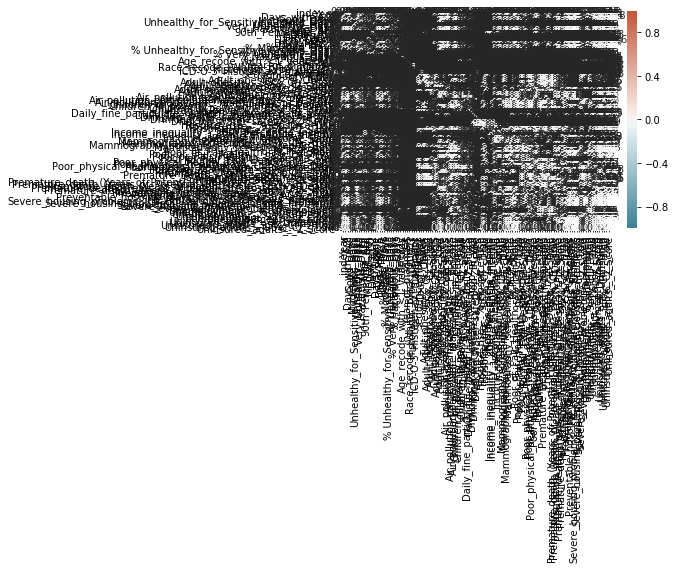

In [46]:
# calculate correlation matrix
corr = merge_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

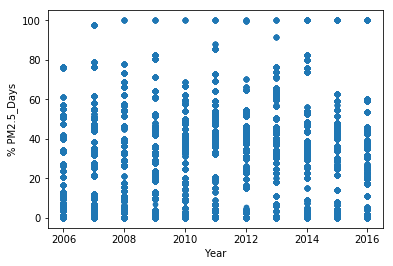

In [48]:
merge_df.plot(kind='scatter', x='Year', y='% PM2.5_Days')

In [ ]:
merge_df.plot(kind='scatter', x='County', y='% PM2.5_Days')

In [ ]:
sns.pairplot(merge_df)

In [31]:
#Let's store the counties from the cancer and aqi dataframe in separate lists so we can see what counties are missing
cancer_counties=list(set(fips_merge.County))

aqi_counties= list(set(aqi_df.County))

missing_counties = [
    list(set(cancer_counties).difference(aqi_counties))
]

print("These are the 4 counties missing from the AQI data:", missing_counties)

These are the 4 counties missing from the AQI data: [['Sierra', 'Modoc', 'Yuba', 'Lassen']]


In [33]:
#We can export our data into a csv
pd.DataFrame.to_csv(dataset, 'dataset.txt', sep=',', na_rep='.', index=False)

In [34]:
#scatter plot
dataset.head()

,index_x,State,County,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,...,index_y,Age_recode_with_<1_year_olds,Sex,Year_of_diagnosis,"Race_recode_(White,_Black,_Other)",Histologic_Type_ICD-O-3,"ICD-O-3_Hist/behav,_malignant",Laterality,Sequence_number,County_Code
0,62.0,California,Alameda,2006,365.0,220.0,123.0,17.0,5.0,0.0,...,1.0,16.0,1.0,206.0,1.0,70.0,283.0,2.0,2.0,6001.0
1,62.0,California,Alameda,2006,365.0,220.0,123.0,17.0,5.0,0.0,...,9.0,12.0,1.0,206.0,1.0,46.0,187.0,1.0,3.0,6001.0
2,62.0,California,Alameda,2006,365.0,220.0,123.0,17.0,5.0,0.0,...,29.0,16.0,1.0,206.0,1.0,140.0,563.0,1.0,2.0,6001.0
3,62.0,California,Alameda,2006,365.0,220.0,123.0,17.0,5.0,0.0,...,31.0,12.0,2.0,206.0,1.0,46.0,187.0,1.0,2.0,6001.0
4,62.0,California,Alameda,2006,365.0,220.0,123.0,17.0,5.0,0.0,...,43.0,16.0,2.0,206.0,1.0,140.0,563.0,1.0,3.0,6001.0


In [35]:
cancer_df.head()

,index,Age_recode_with_<1_year_olds,Sex,Year_of_diagnosis,"Race_recode_(White,_Black,_Other)",Histologic_Type_ICD-O-3,"ICD-O-3_Hist/behav,_malignant",Laterality,Sequence_number,County_Code,Year
0,0,16,2,206,1,250,1003,2,2,6013,2006
1,1,16,1,206,1,70,283,2,2,6001,2006
2,2,15,2,207,1,46,187,1,2,6013,2007
3,3,16,2,211,1,10,43,2,3,6075,2011
4,4,16,2,209,1,140,563,1,2,6075,2009


In [36]:
dataset.groupby(["Year","County"]).count().reset_index()

,Year,County,index_x,State,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,...,index_y,Age_recode_with_<1_year_olds,Sex,Year_of_diagnosis,"Race_recode_(White,_Black,_Other)",Histologic_Type_ICD-O-3,"ICD-O-3_Hist/behav,_malignant",Laterality,Sequence_number,County_Code
0,2006,Alameda,677,677,677,677,677,677,677,677,...,677,677,677,677,677,677,677,677,677,677
1,2006,Amador,34,34,34,34,34,34,34,34,...,34,34,34,34,34,34,34,34,34,34
2,2006,Butte,191,191,191,191,191,191,191,191,...,191,191,191,191,191,191,191,191,191,191
3,2006,Calaveras,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
4,2006,Colusa,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
5,2006,Contra Costa,548,548,548,548,548,548,548,548,...,548,548,548,548,548,548,548,548,548,548
6,2006,Del Norte,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
7,2006,El Dorado,115,115,115,115,115,115,115,115,...,115,115,115,115,115,115,115,115,115,115
8,2006,Fresno,388,388,388,388,388,388,388,388,...,388,388,388,388,388,388,388,388,388,388
9,2006,Glenn,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
